Output()

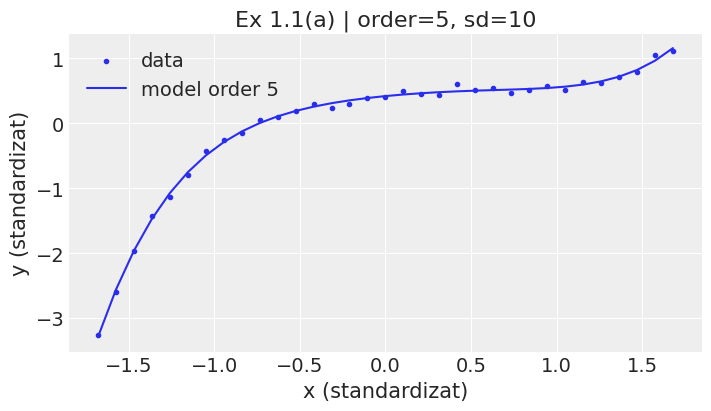

Output()

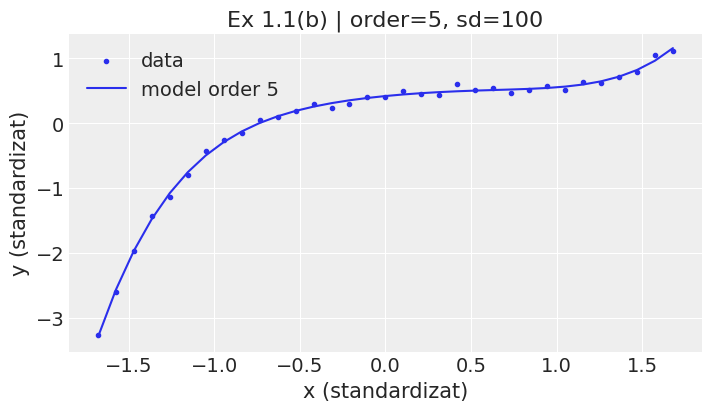

Output()

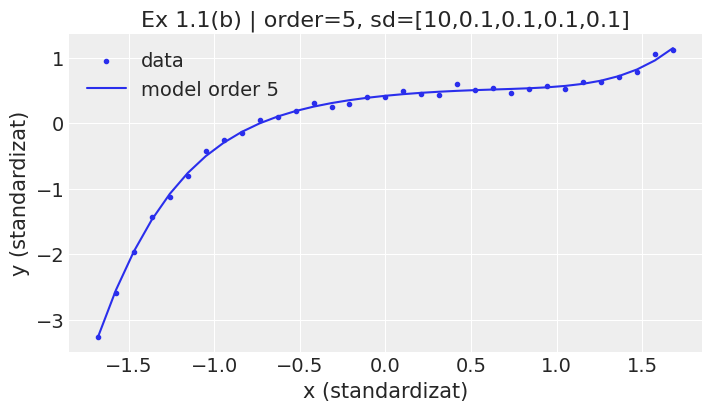

Output()

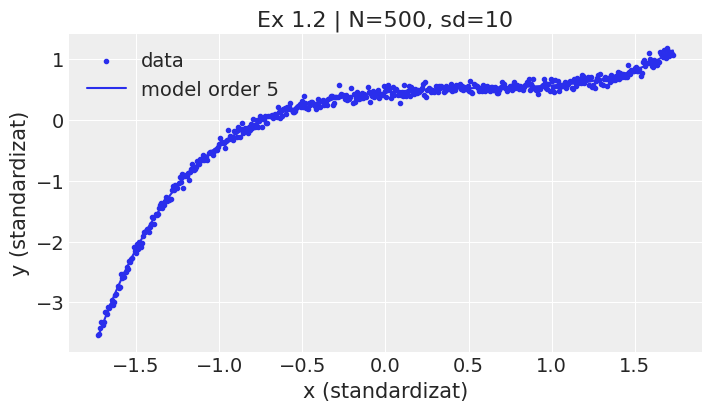

Output()

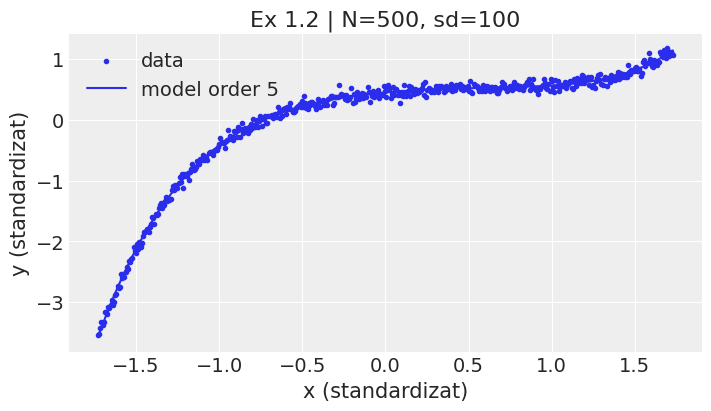

Output()

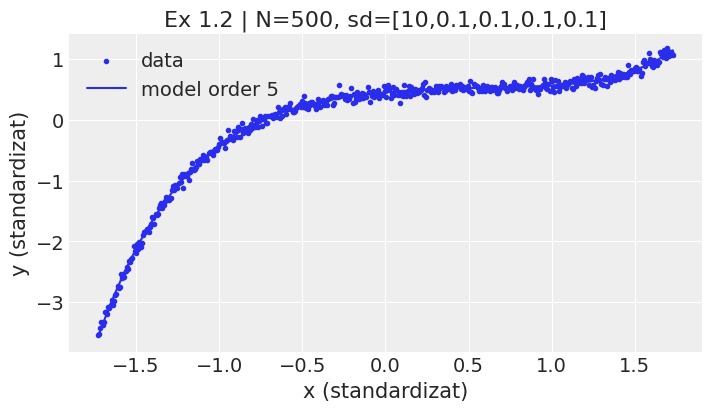

Output()

Output()

Output()

Output()

Output()

Output()

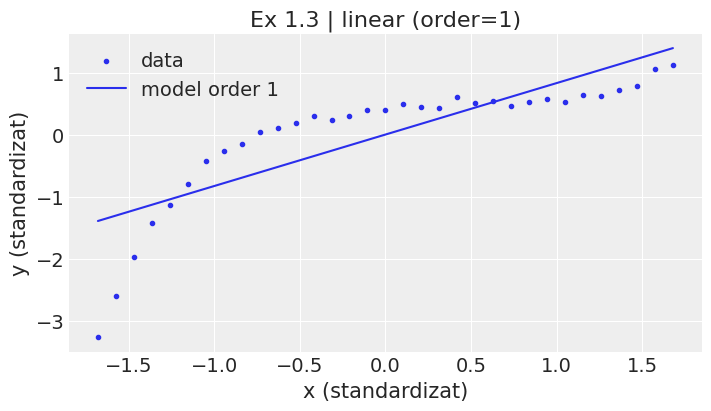

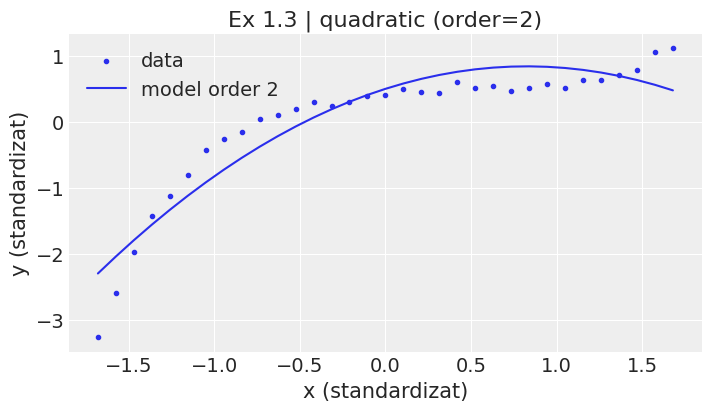

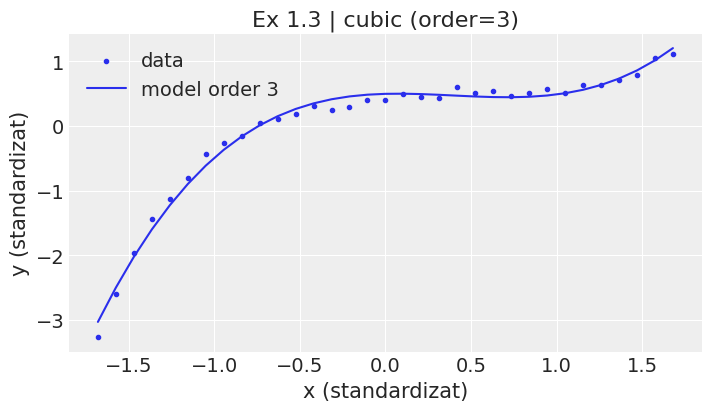

Ex 1.3 | WAIC compare:


/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is gr

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
cubic,0,-48.074159,5.457494,0.000000,1.000000e+00,9.124432,0.000000,True,deviance
quadratic,1,33.703576,5.194529,81.777735,1.116923e-15,10.344693,7.090787,True,deviance
linear,2,64.206824,4.430923,112.280983,1.214664e-21,13.751702,8.882241,True,deviance


Ex 1.3 | LOO compare:


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
cubic,0,-47.264842,5.862153,0.000000,1.000000e+00,9.866182,0.000000,True,deviance
quadratic,1,34.193441,5.439462,81.458283,3.912035e-16,10.610115,7.065949,True,deviance
linear,2,64.804362,4.729692,112.069204,2.703153e-22,14.300760,8.860146,True,deviance


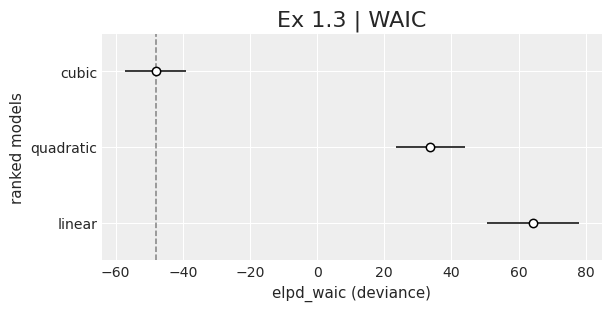

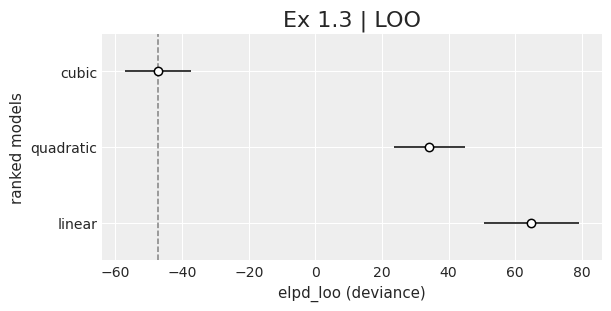

In [4]:
!pip -q install pymc arviz numpy scipy matplotlib pandas

import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import os

az.style.use('arviz-darkgrid')
np.random.seed(42)

os.makedirs("data", exist_ok=True)
csv_path = "data/dummy.csv"

def generate_dummy_csv(path, n=33, true_order=5, noise=0.35):
    x = np.linspace(-2.5, 2.5, n)
    beta_true = np.array([1.0, -0.8, 0.35, -0.12, 0.06])
    if true_order != 5:
        beta_true = np.random.normal(0, 0.6, size=true_order)
    X = np.vstack([x**i for i in range(1, true_order+1)])
    y = 0.2 + beta_true @ X + np.random.normal(0, noise, size=n)
    pd.DataFrame({"x": x, "y": y}).to_csv(path, index=False)
    return x, y

if not os.path.exists(csv_path):
    generate_dummy_csv(csv_path, n=33, true_order=5, noise=0.35)

df = pd.read_csv(csv_path)
x_1 = df.iloc[:, 0].to_numpy()
y_1 = df.iloc[:, 1].to_numpy()

def make_design_and_standardize(x, y, order):
    x_p = np.vstack([x**i for i in range(1, order+1)])
    x_s = (x_p - x_p.mean(axis=1, keepdims=True)) / x_p.std(axis=1, keepdims=True)
    y_s = (y - y.mean()) / y.std()
    return x_s, y_s

def fit_polynomial_model(x_s, y_s, order, beta_sigma=10, draws=2000, tune=1000, target_accept=0.9):
    with pm.Model() as model_p:
        α = pm.Normal("α", mu=0, sigma=1)
        β = pm.Normal("β", mu=0, sigma=beta_sigma, shape=order)
        ϵ = pm.HalfNormal("ϵ", sigma=5)
        µ = α + pm.math.dot(β, x_s)
        y_pred = pm.Normal("y_pred", mu=µ, sigma=ϵ, observed=y_s)
        idata = pm.sample(draws=draws, tune=tune, target_accept=target_accept, return_inferencedata=True, chains=2)
    return model_p, idata

def plot_fit_mean_curve(x_s, y_s, idata, order, title=""):
    α_post = idata.posterior["α"].mean(("chain", "draw")).values
    β_post = idata.posterior["β"].mean(("chain", "draw")).values
    idx = np.argsort(x_s[0])
    y_hat = α_post + np.dot(β_post, x_s)
    plt.figure(figsize=(7,4))
    plt.scatter(x_s[0], y_s, marker='.', label="data")
    plt.plot(x_s[0][idx], y_hat[idx], label=f"model order {order}")
    plt.xlabel("x (standardizat)")
    plt.ylabel("y (standardizat)")
    plt.title(title)
    plt.legend()
    plt.show()

def fit_and_add_ll(x_s, y_s, order, beta_sigma=10):
    model, idata = fit_polynomial_model(x_s, y_s, order=order, beta_sigma=beta_sigma)
    pm.compute_log_likelihood(idata, model=model)
    return model, idata

# Ex 1.1(a)
order = 5
x_1s, y_1s = make_design_and_standardize(x_1, y_1, order=order)
model_p5, idata_p5 = fit_polynomial_model(x_1s, y_1s, order=order, beta_sigma=10)
plot_fit_mean_curve(x_1s, y_1s, idata_p5, order=order, title="Ex 1.1(a) | order=5, sd=10")

# Ex 1.1(b) sd=100
model_p5_s100, idata_p5_s100 = fit_polynomial_model(x_1s, y_1s, order=5, beta_sigma=100)
plot_fit_mean_curve(x_1s, y_1s, idata_p5_s100, order=5, title="Ex 1.1(b) | order=5, sd=100")

# Ex 1.1(b) sd=np.array([10,0.1,0.1,0.1,0.1])
beta_sd_vec = np.array([10, 0.1, 0.1, 0.1, 0.1])
model_p5_vec, idata_p5_vec = fit_polynomial_model(x_1s, y_1s, order=5, beta_sigma=beta_sd_vec)
plot_fit_mean_curve(x_1s, y_1s, idata_p5_vec, order=5, title="Ex 1.1(b) | order=5, sd=[10,0.1,0.1,0.1,0.1]")

# Ex 1.2 (N=500) sd=10, sd=100, sd=vector
x_big, y_big = generate_dummy_csv("data/dummy_500.csv", n=500, true_order=5, noise=0.35)
x_bs, y_bs = make_design_and_standardize(x_big, y_big, order=5)

_, id10 = fit_polynomial_model(x_bs, y_bs, order=5, beta_sigma=10)
plot_fit_mean_curve(x_bs, y_bs, id10, order=5, title="Ex 1.2 | N=500, sd=10")

_, id100 = fit_polynomial_model(x_bs, y_bs, order=5, beta_sigma=100)
plot_fit_mean_curve(x_bs, y_bs, id100, order=5, title="Ex 1.2 | N=500, sd=100")

_, idvec = fit_polynomial_model(x_bs, y_bs, order=5, beta_sigma=np.array([10,0.1,0.1,0.1,0.1]))
plot_fit_mean_curve(x_bs, y_bs, idvec, order=5, title="Ex 1.2 | N=500, sd=[10,0.1,0.1,0.1,0.1]")

# Ex 1.3 (order=3) WAIC + LOO + plot + compare vs order=1,2
x_s3, y_s3 = make_design_and_standardize(x_1, y_1, order=3)
x_lin = x_s3[:1, :]
x_quad = x_s3[:2, :]
x_cub = x_s3[:3, :]

_, id_l = fit_and_add_ll(x_lin,  y_s3, order=1, beta_sigma=10)
_, id_q = fit_and_add_ll(x_quad, y_s3, order=2, beta_sigma=10)
_, id_c = fit_and_add_ll(x_cub,  y_s3, order=3, beta_sigma=10)

plot_fit_mean_curve(x_lin,  y_s3, id_l, order=1, title="Ex 1.3 | linear (order=1)")
plot_fit_mean_curve(x_quad, y_s3, id_q, order=2, title="Ex 1.3 | quadratic (order=2)")
plot_fit_mean_curve(x_cub,  y_s3, id_c, order=3, title="Ex 1.3 | cubic (order=3)")

cmp_waic = az.compare({"linear": id_l, "quadratic": id_q, "cubic": id_c}, ic="waic", method="BB-pseudo-BMA", scale="deviance")
cmp_loo  = az.compare({"linear": id_l, "quadratic": id_q, "cubic": id_c}, ic="loo",  method="BB-pseudo-BMA", scale="deviance")

print("Ex 1.3 | WAIC compare:")
display(cmp_waic)

print("Ex 1.3 | LOO compare:")
display(cmp_loo)

az.plot_compare(cmp_waic, insample_dev=False)
plt.title("Ex 1.3 | WAIC")
plt.show()

az.plot_compare(cmp_loo, insample_dev=False)
plt.title("Ex 1.3 | LOO")
plt.show()
